In [23]:
! pip install -q lalsuite==7.11 bilby==2.0.1 gwpy==3.0.4 matplotlib==3.5.3 dynesty==2.1.1

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

## GW150914



In [25]:
time_of_event = 1126259462.4

In [26]:
H1=bilby.gw.detector.get_empty_interferometer('H1')
L1=bilby.gw.detector.get_empty_interferometer('L1')

In [27]:
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

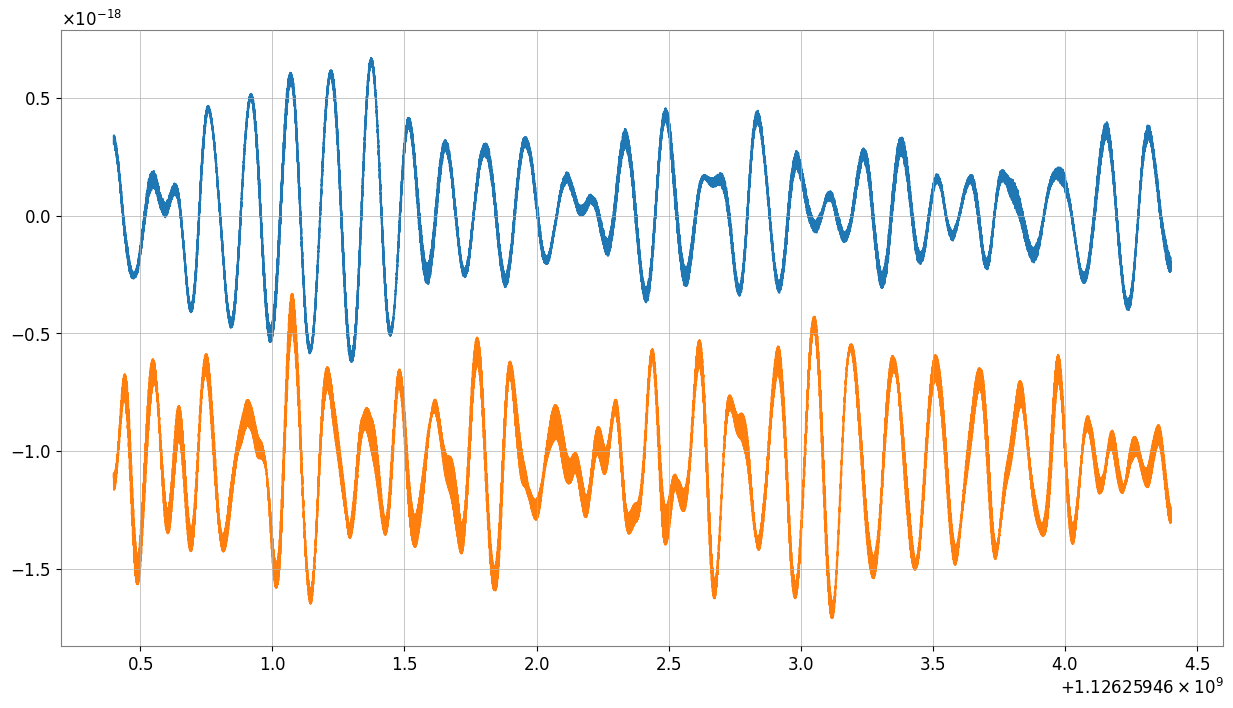

In [28]:
plt.figure(figsize=(15,8))
plt.plot(H1_analysis_data)
plt.plot(L1_analysis_data)

In [29]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

In [30]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

In [31]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("hann"), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("hann"), method="median")

In [32]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

17:55 bilby INFO    : Generating frequency domain strain from given time domain strain.
17:55 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


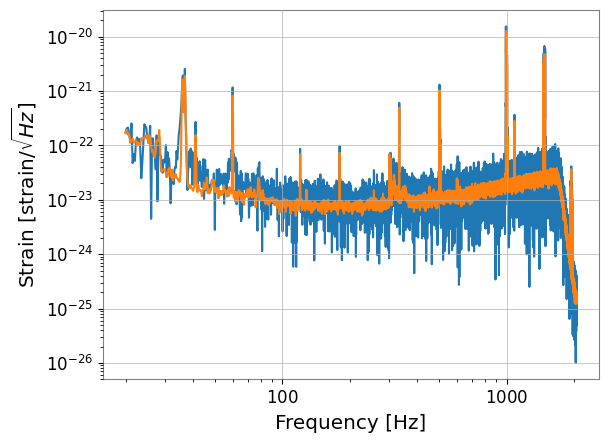

In [33]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

In [34]:
#Not interested in very high frequency components

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

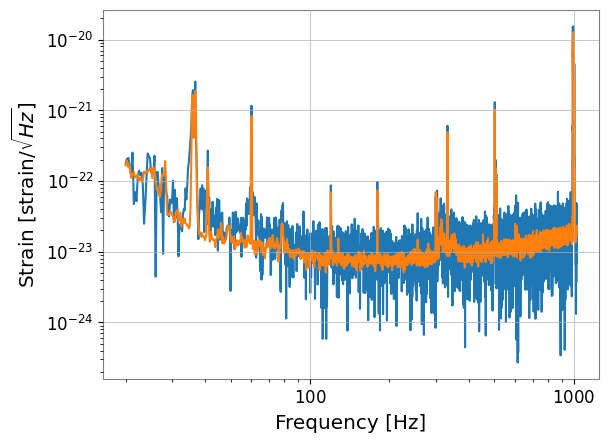

In [35]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

## Low dimensional analysis



$$ Chirp Mass \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1} $$



Delta function priors for everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values.

In [36]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


In [37]:
interferometers = [H1, L1]

waveform_arguments = dict(
    waveform_approximant='IMRPhenomD', reference_frequency=100., catch_waveform_errors=True)

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True,
    phase_marginalization=True,
    distance_marginalization=True)

17:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
17:55 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


In [16]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    clean=True,
)

16:45 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
16:45 bilby INFO    : Using lal version 7.2.4
16:45 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
16:45 bilby INFO    : Using lalsimulation version 4.0.2
16:45 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
16:45 bilby INFO    : Analysis priors:
16:45 bilby INFO    : chirp_mass=Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
16:45 bilby INFO    : mass_ratio=Uniform(mi

1it [00:00, ?it/s]

16:56 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:07 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:17 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:27 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:38 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:47 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
17:47 bilby INFO    : Rejection sampling nested samples to obtain 1505 posterior samples
17:47 bilby INFO    : Sampling time: 1:01:26.368924


17:47 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/1505 [00:00<?, ?it/s]

17:50 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/1505 [00:00<?, ?it/s]

17:52 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/1505 [00:00<?, ?it/s]

17:52 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/1505 [00:00<?, ?it/s]

17:54 bilby INFO    : Summary of results:
nsamples: 1505
ln_noise_evidence: -85904.722
ln_evidence: -85597.635 +/-  0.076
ln_bayes_factor: 307.086 +/-  0.076



In [17]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,30.554434,0.837798,0.000071,4.954558,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.065744,286.469224,36.007870,30.167332,28.669594,66.175202
1,32.275604,0.965318,-0.000145,1.549097,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.064048,279.196131,35.464795,34.234794,30.332839,69.699589
2,31.752743,0.696999,-0.000123,1.530260,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.065233,284.278058,41.146591,28.679126,29.808271,69.825717
3,30.566036,0.930480,0.000231,4.970975,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.066742,290.750968,34.126250,31.753778,28.653629,65.880028
4,30.714694,0.962647,0.000021,1.970054,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.065387,284.942048,33.754115,32.493314,28.829601,66.247429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,31.397016,0.975901,-0.000081,4.901258,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.064521,281.223831,34.296023,33.469535,29.494040,67.765558
1501,31.341182,0.984965,-0.000087,4.949581,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.061956,270.211125,34.159138,33.645570,29.512698,67.804708
1502,31.394593,0.998551,-0.000092,4.881571,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.067905,295.735220,33.794268,33.745288,29.398290,67.539556
1503,31.353450,0.968875,-0.000067,1.722684,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.066142,288.175766,34.320493,33.252259,29.408338,67.572753


In [18]:
Mc = result_short.posterior["chirp_mass"].values

In [19]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.264239497183716 with a 90% C.I = 30.823289228901086 -> 31.719525994038545


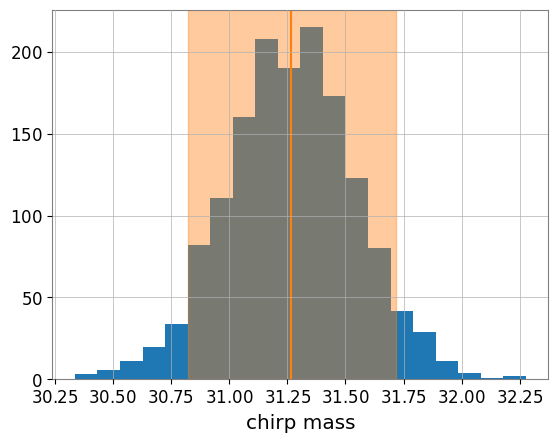

In [20]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

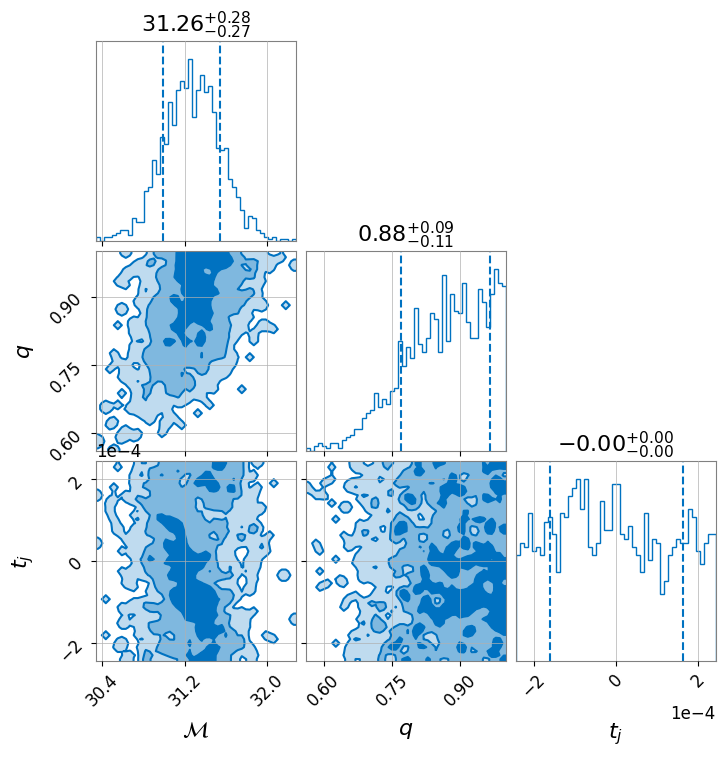

In [21]:
result_short.plot_corner()

In [22]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 307.0863643599914 +/- 0.07624814843226266
